### Hidden Markov Model


In [ ]:
class HMM:
    def __init__(self, tagset):
        self.k=0.0001
        self.tagset = tagset

    def train(self, sents):
        self.emit = {}
        self.trans = {}
        self.freq = {}
        for sent in sents:
            prev_tag='^'
            for ind, word in enumerate(sent):
                word_tag = (word[0].lower(), word[1])
                bigram = (prev_tag, word[1])
                self.emit[word_tag] = self.emit.get(word_tag, 0) + 1
                self.freq[word[1]] = self.freq.get(word[1], 0) + 1
                if ind != 0:
                    self.trans[bigram] = self.trans.get(bigram, 0) + 1
                    prev_tag = word[1]
        for tag in self.tagset:
            self.freq[tag] = self.freq.get(tag, 0)


    def laplace_trans(self, bigram):
        return (self.trans.get(bigram, 0)+self.k)/(self.freq[bigram[0]]+len(self.tagset)*self.k)


    def laplace_emit(self, word_tag):
        return (self.emit.get(word_tag, 0)+self.k)/(self.freq[word_tag[1]]+len(self.tagset)*self.k)


    def pos_tag(self, sent):
        dp = {}
        back = {}
        for ind, word in enumerate(sent):
            word = word.lower()
            if ind == 0:
                for tag in self.tagset:
                    word_tag = (word, tag)
                    dp[(ind, tag)] = self.laplace_emit(word_tag)
                continue
            for tag in self.tagset:
                dp[(ind, tag)] = -1
                for prev_tag in self.tagset:
                    bigram = (prev_tag, tag)
                    word_tag = (word, tag)
                    prob = dp[(ind-1, prev_tag)]*self.laplace_trans(bigram)*self.laplace_emit(word_tag)
                    if dp[(ind, tag)] < prob:
                        dp[(ind, tag)] = prob
                        back[(ind, tag)] = prev_tag
        tags = []
        max_prob = -1
        for tag in self.tagset:
            if max_prob < dp[len(sent)-1, tag]:
                max_prob = dp[len(sent)-1, tag]
                tags = [tag]

        for ind in range(len(sent)-1, 0, -1):
            tags.append(back[(ind, tags[-1])])
        tags.reverse()
        return tags

### Data

Dataset used is Brown Corpus from nltk library

In [ ]:
import nltk

CORPUS_NAME = 'brown'
nltk.download(CORPUS_NAME)
nltk.download('universal_tagset')
CORPUS = nltk.corpus.brown
UNIVERSAL_TAGS = ("VERB","NOUN","PRON","ADJ","ADV","ADP","CONJ","DET","NUM","PRT","X",".")

sents = CORPUS.tagged_sents(tagset='universal')
print(len(sents))

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
57340


### Testing model - k fold cross validation


In [ ]:
def test(model, test_set):
    confusion_double_dict = {x:{y:0 for y in UNIVERSAL_TAGS} for x in UNIVERSAL_TAGS}
    for sent in test_set:
        obtained_tags = model.pos_tag([word_tag[0] for word_tag in sent])
        true_tags = [word_tag[1] for word_tag in sent]
        for i in range(len(sent)):
            confusion_double_dict[true_tags[i]][obtained_tags[i]]+=1
    return confusion_double_dict

In [ ]:
#import random

def k_fold_cross_validate(sents, folds = 5):
    #random.shuffle(sents)
    print(f'Started {folds} fold validation')
    step = len(sents)//folds
    l,r,summary,model = 0,step,[],None
    for i in range(folds):
        print(f'\nIn fold {i+1} :')
        model = HMM(UNIVERSAL_TAGS)
        train_set = sents[:l]+sents[r:]
        test_set = sents[l:r]
        print(f'Started training')
        model.train(train_set)
        print(f'Training done!')
        confusion_dd = test(model, test_set)
        print('Computed confusion matrix sucessfully!\n')
        summary.append(confusion_dd)
        l += step
        r += step
    return summary,model

summary,model = k_fold_cross_validate(sents)

# test_sent = "My name is Mr.X . I am a student from CSE Department ."
# print(test_sent,"\n"," ".join(model.pos_tag(test_sent.split())))

Started 5 fold validation

In fold 1 :
Started training
Training done!
Computed confusion matrix sucessfully!


In fold 2 :
Started training
Training done!
Computed confusion matrix sucessfully!


In fold 3 :
Started training
Training done!
Computed confusion matrix sucessfully!


In fold 4 :
Started training
Training done!
Computed confusion matrix sucessfully!


In fold 5 :
Started training
Training done!
Computed confusion matrix sucessfully!



### Summary of Results

--------------------- Overall Summary  Average ---------------------

Accuracy             Recall               Precision           
0.9384238691097814   0.91446748040935     0.84265504190403    

F-1 score            F-0.5 score          F-2 score           
0.8770829426002388   0.8560943613571308   0.899134734931302   

--------------------- Per Tag summary ---------------------


Tag             Precision            Recall               F1 Score            
VERB            0.9667373255624018   0.9478995518399934   0.9572089198820418  
NOUN            0.9675477173653446   0.8818793672327179   0.9226904701433627  
PRON            0.9368499367121956   0.9628774058694265   0.9496060601831721  
ADJ             0.8901339371580137   0.9016368748921056   0.8958104862604216  
ADV             0.8729085190584952   0.8920640647215541   0.8823551725401287  
ADP             0.9408964435261626   0.9611735399332803   0.9509002040396586  
CONJ            0.9471800074916151   0.9870436957551156   0.9

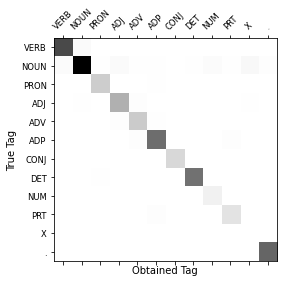

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def calculate_results(conf_dd): # summary is a confusion double dictionary
    total_fpos = 0
    total_tpos = 0
    total_fnegs = 0
    total_obvs = 0
    tpos = {}
    fpos = {}
    fneg = {}
    for true_tag,row in conf_dd.items(): # x is true tag, z is obtained tag
        for obtained_tag,count in row.items():
            total_obvs += count
            if true_tag == obtained_tag:
                total_tpos += count
                tpos[true_tag] = count
            else:
                total_fnegs+=count
                total_fpos +=count
                fneg[true_tag] = fneg.get(true_tag, 0) + count
                fpos[obtained_tag] = fpos.get(obtained_tag, 0) + count
    precision,recall,f1 = {},{},{}
    #print("\n--------------------- Per Tag summary ---------------------\n")
    #print("\n{:<15} {:<20} {:<20} {:<20}".format('Tag','Precision','Recall','F1 Score'))
    for tag in UNIVERSAL_TAGS:
        precision[tag] = tpos.get(tag, 0)/(tpos.get(tag, 0)+fpos.get(tag, 0))
        recall[tag] = tpos.get(tag, 0)/(tpos.get(tag, 0)+fneg.get(tag, 0))
        f1[tag] = (2*precision[tag]*recall[tag])/(precision[tag]+recall[tag])
        #print("{:<15} {:<20} {:<20} {:<20}".format(tag, precision[tag], recall[tag], f1[tag]))
    # overall performance summary
    overall_accuracy = total_tpos/total_obvs
    overall_recall = sum(recall.values())/len(UNIVERSAL_TAGS) #macro avg, bcoz micro avg is driven by majority class
    overall_precision = sum(precision.values())/len(UNIVERSAL_TAGS) #macro avg
    f_scores = [(1+x**2)*(overall_precision*overall_recall)/(x**2*overall_precision+overall_recall) for x in [1,0.5,2]]
    #print("\n--------------------- Overall Summary ---------------------\n")
    #print("{:<20} {:<20} {:<20}".format('Accuracy','Recall','Percision'))
    #print("{:<20} {:<20} {:<20}".format(overall_accuracy,overall_recall,overall_precision))
    #print("\n{:<20} {:<20} {:<20}".format('F-1 score','F-0.5 score','F-2 score'))
    #print("{:<20} {:<20} {:<20}".format(*f_scores))
    #print("\n--------------------- Confusion Matrix ---------------------\n")
    confusion_matrix = [[0 for _ in range(12)] for _ in range(12)]
    i,j = 0,0
    for x in UNIVERSAL_TAGS: # x is true tag
        normal = sum([b for (a,b) in conf_dd[x].items()])
        for y in UNIVERSAL_TAGS: # y is obtained tag
            confusion_matrix[i][j] = conf_dd[x][y] #/normal
            j+=1
        i+=1
        j=0
    #plt.matshow(confusion_matrix, cmap='binary')
    #plt.xlabel("Obtained Tag")
    #plt.ylabel("True Tag")
    #plt.xticks(range(len(UNIVERSAL_TAGS)), UNIVERSAL_TAGS, size='small')
    #plt.yticks(range(len(UNIVERSAL_TAGS)), UNIVERSAL_TAGS, size='small')
    #plt.show()
    return (overall_accuracy,overall_recall,overall_precision,f_scores,precision,recall,f1,confusion_matrix)

i = 0
overall_accuracy,overall_recall,overall_precision,f_scores,precision,recall,f1 = 0,0,0,[0,0,0],{},{},{}
confusion_matrix = [[0 for _ in range(12)] for _ in range(12)]
for s in summary:
    #print(f'For fold {i}: \n\n')
    i+=1
    overall_accuracy_tc,overall_recall_tc,overall_precision_tc,f_scores_tc,precision_tc,recall_tc,f1_tc,confusion_matrix_tc = calculate_results(s)
    overall_accuracy += overall_accuracy_tc
    overall_precision += overall_precision_tc
    overall_recall += overall_recall_tc
    for i in range(len(f_scores)):
        f_scores[i] += f_scores_tc[i]
    for tag in UNIVERSAL_TAGS:
        precision[tag] = precision.get(tag,0)+precision_tc[tag]
        recall[tag] = recall.get(tag,0)+recall_tc[tag]
        f1[tag] = f1.get(tag,0)+f1_tc[tag]
    for i in range(12):
        for j in range(12):
            confusion_matrix[i][j]+=confusion_matrix_tc[i][j]

folds = len(summary)
overall_accuracy /= folds
overall_precision /= folds
overall_recall /= folds
for i in range(len(f_scores)):
    f_scores[i] /= folds
for tag in UNIVERSAL_TAGS:
    precision[tag] /= folds
    recall[tag] /= folds
    f1[tag] /= folds
print("--------------------- Overall Summary  Average ---------------------\n")
print("{:<20} {:<20} {:<20}".format('Accuracy','Recall','Precision'))
print("{:<20} {:<20} {:<20}".format(overall_accuracy,overall_recall,overall_precision))
print("\n{:<20} {:<20} {:<20}".format('F-1 score','F-0.5 score','F-2 score'))
print("{:<20} {:<20} {:<20}".format(*f_scores))
print("\n--------------------- Per Tag summary ---------------------\n")
print("\n{:<15} {:<20} {:<20} {:<20}".format('Tag','Precision','Recall','F1 Score'))
for tag in UNIVERSAL_TAGS:
    print("{:<15} {:<20} {:<20} {:<20}".format(tag, precision[tag], recall[tag], f1[tag]))
print("\n--------------------- Confusion Matrix ---------------------\n")
plt.matshow(confusion_matrix, cmap='binary')#, interpolation='nearest')
plt.xlabel("Obtained Tag")
plt.ylabel("True Tag")
plt.xticks(range(len(UNIVERSAL_TAGS)), UNIVERSAL_TAGS, size='small', rotation = 45)
plt.yticks(range(len(UNIVERSAL_TAGS)), UNIVERSAL_TAGS, size='small')
plt.show()

